## 1. Load packages

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 2. Load data

In [2]:
data=duckdb.read_parquet("/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/openness.parquet") 

## 3. Exploration

In [45]:
data

┌─────────┬─────────┬─────────┬────────────────────────┐
│   chr   │  start  │   end   │        openness        │
│ varchar │  int64  │  int64  │         double         │
├─────────┼─────────┼─────────┼────────────────────────┤
│ chr1    │       0 │     500 │                    0.0 │
│ chr1    │     500 │    1000 │                    0.0 │
│ chr1    │    1000 │    1500 │                    0.0 │
│ chr1    │    1500 │    2000 │                    0.0 │
│ chr1    │    2000 │    2500 │                    0.0 │
│ chr1    │    2500 │    3000 │                    0.0 │
│ chr1    │    3000 │    3500 │                    0.0 │
│ chr1    │    3500 │    4000 │                    0.0 │
│ chr1    │    4000 │    4500 │                    0.0 │
│ chr1    │    4500 │    5000 │                    0.0 │
│  ·      │      ·  │      ·  │                     ·  │
│  ·      │      ·  │      ·  │                     ·  │
│  ·      │      ·  │      ·  │                     ·  │
│ chr1    │ 4995000 │ 4995500 │

In [3]:
query = f"""
SELECT * 
FROM data
"""
openness = duckdb.query(query).df()

print(openness.head())

    chr  start   end  openness
0  chr1      0   500       0.0
1  chr1    500  1000       0.0
2  chr1   1000  1500       0.0
3  chr1   1500  2000       0.0
4  chr1   2000  2500       0.0


### 3.1 outliers

In [47]:
openness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6062095 entries, 0 to 6062094
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   chr       object 
 1   start     int64  
 2   end       int64  
 3   openness  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 185.0+ MB


In [48]:
openness.shape

(6062095, 4)

In [49]:
openness.describe()

,start,end,openness
count,6.062095e+06,6.062095e+06,6.062095e+06
mean,7.769376e+07,7.769426e+07,2.379201e-03
std,5.498636e+07,5.498636e+07,8.797779e-03
min,0.000000e+00,5.000000e+02,0.000000e+00
25%,3.294600e+07,3.294650e+07,7.479761e-04
50%,6.815400e+07,6.815450e+07,1.165963e-03
75%,1.135490e+08,1.135495e+08,1.693946e-03
max,2.489560e+08,2.489564e+08,4.679470e-01


In [50]:
openness_mean = openness['openness'].mean()  
openness_std = openness['openness'].std()  
outliers = openness['openness'].apply(lambda x: np.abs((x - openness_mean) / openness_std) > 3)
# print(openness, " outliers:")
print(openness[outliers])  


          chr      start        end  openness
1557     chr1     778500     779000  0.127728
1634     chr1     817000     817500  0.050840
1654     chr1     827000     827500  0.048838
1655     chr1     827500     828000  0.046946
1739     chr1     869500     870000  0.035265
...       ...        ...        ...       ...
6060156  chrX  155071500  155072000  0.048420
6060445  chrX  155216000  155216500  0.086787
6060446  chrX  155216500  155217000  0.050532
6061238  chrX  155612500  155613000  0.042767
6061775  chrX  155881000  155881500  0.076668

[70109 rows x 4 columns]


## 3.2 openness == 0 

In [4]:
definitely_not_open=openness.loc[openness['openness']==0, :]

In [5]:
definitely_not_open.shape

(431984, 4)

In [6]:
definitely_not_open.shape[0]/openness.shape[0]

0.07125985323555635

In [7]:
highly_open=openness.loc[openness['openness']>0.45, :]

In [8]:
highly_open

,chr,start,end,openness
2478714,chr19,10871000,10871500,0.467243
5387423,chr8,102239000,102239500,0.467947


## 3.3 Vis

{'whiskers': [<matplotlib.lines.Line2D at 0x152f0c34e330>,
 'caps': [<matplotlib.lines.Line2D at 0x152f0cda6db0>,
 'boxes': [<matplotlib.lines.Line2D at 0x152f0c917980>],
 'medians': [<matplotlib.lines.Line2D at 0x153000063560>],
 'fliers': [<matplotlib.lines.Line2D at 0x152fe95f8e90>],
 'means': []}

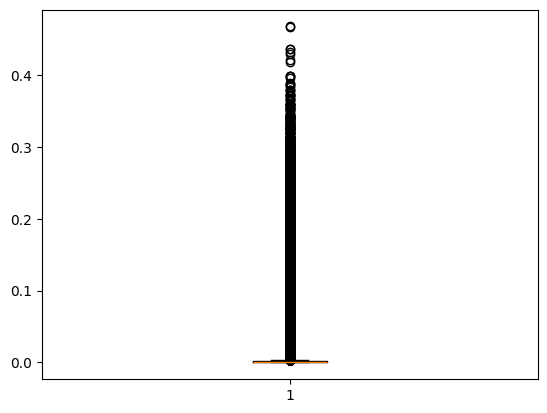

In [56]:
plt.boxplot(openness['openness'])

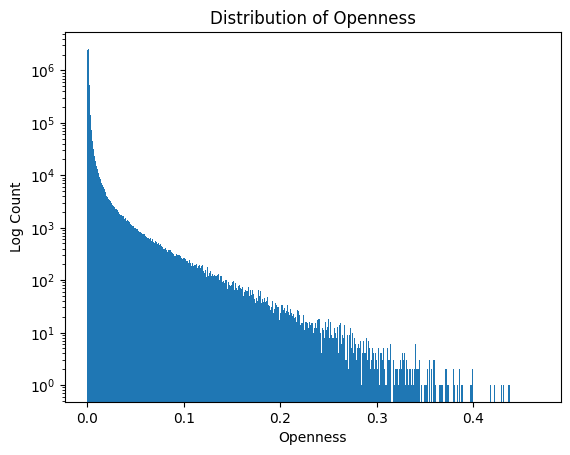

In [9]:
plt.hist(openness['openness'], bins=np.arange(min(openness['openness']), max(openness['openness']), 0.001)) 
plt.yscale('log')
plt.xlabel('Openness')
plt.ylabel('Log Count')
plt.title('Distribution of Openness')
plt.show()

## 4. expanded SNPs

In [10]:
parquet_file_path="/lustre1/project/stg_00079/students/tingting/data/GWAS/020results_expansion/Bellenguez_etal_Stage1_result.expanded.parquet"

In [11]:
snps=duckdb.read_parquet(parquet_file_path)

### 4.1 preprocessing

In [12]:
query=f"""
SELECT * FROM snps LIMIT 10
"""
duckdb.query(query)

┌────────────┬───────────┬───────────┬─────────┬──────────┬───┬──────────────┬────────────┬─────────────┬─────────┐
│ Chromosome │ start_pos │  snp_pos  │  rsid   │ r_square │ … │ start_pos_AD │ snp_pos_AD │   rsid_AD   │ p_value │
│  varchar   │   int64   │   int64   │ varchar │ varchar  │   │    int64     │   int64    │   varchar   │ double  │
├────────────┼───────────┼───────────┼─────────┼──────────┼───┼──────────────┼────────────┼─────────────┼─────────┤
│ chr10      │  80874308 │  80874309 │ .       │ .        │ … │     80874308 │   80874309 │ rs7923241   │ 0.09999 │
│ chr1       │ 169826188 │ 169826189 │ .       │ .        │ … │    169826188 │  169826189 │ rs145942373 │ 0.09999 │
│ chr12      │   4625904 │   4625905 │ .       │ .        │ … │      4625904 │    4625905 │ rs12311760  │ 0.09999 │
│ chr1       │  80514774 │  80514775 │ .       │ .        │ … │     80514774 │   80514775 │ rs548690190 │ 0.09999 │
│ chr16      │  80018548 │  80018549 │ .       │ .        │ … │     8001

In [13]:
query = f"""
SELECT Chromosome,
       start_pos,
       snp_pos,
       rsid,
       r_square AS stats
FROM snps

UNION ALL

SELECT Chromosome_AD AS Chromosome, 
       start_pos_AD AS start_pos, 
       snp_pos_AD AS snp_pos, 
       rsid_AD AS rsid, 
       p_value AS stats
FROM snps;
"""

snps_long = duckdb.query(query).df()

In [14]:
# Convert 'stats' to numeric, setting errors='coerce' to handle "." values by converting them to NaN
snps_long['stats'] = pd.to_numeric(snps_long['stats'], errors='coerce')
snps_long['stats'] = np.where(snps_long['stats'] <= 0.1, 0, snps_long['stats']) # 0 lead snp, 1 LD snp
snps_long['stats'] = np.where(snps_long['stats'] >= 0.8, 1, snps_long['stats'])

In [15]:
# Drop rows where 'stats' is NaN (which were originally ".")
snps_long.dropna(subset=['stats'], inplace=True)

In [16]:
sum(snps_long.duplicated())

1337746

In [18]:
snps_long=snps_long.drop_duplicates()

In [19]:
snps_long.shape

(2873625, 5)

In [20]:
# load to duckdb
duckdb.register('snps_long_view', snps_long)

In [21]:
# 4211371 snps
duckdb.query("SELECT COUNT(*) FROM snps_long")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      2873625 │
└──────────────┘

In [22]:
duckdb.query("SELECT COUNT(*), stats FROM snps_long GROUP BY stats")

┌──────────────┬────────┐
│ count_star() │ stats  │
│    int64     │ double │
├──────────────┼────────┤
│       465207 │    1.0 │
│      2408418 │    0.0 │
└──────────────┴────────┘

In [27]:
465207/2873625

0.16188855539605898

### 4.2 Join table

In [25]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.openness,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps_long s
JOIN
    data pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.start + 500;
"""
snps_peaks_joined_table=duckdb.query(query)

In [70]:
# stats: 0 lead snp, 1 LD snp
query=f"""
SELECT * FROM snps_peaks_joined_table LIMIT 10
"""
duckdb.query(query)

┌─────────┬──────────┬────────────────────────┬───────────┬──────────┬─────────────┬────────┐
│   chr   │  start   │        openness        │ start_pos │ snp_pos  │    rsid     │ stats  │
│ varchar │  int64   │         double         │   int64   │  int64   │   varchar   │ double │
├─────────┼──────────┼────────────────────────┼───────────┼──────────┼─────────────┼────────┤
│ chr16   │ 74556500 │   0.001077965505103837 │  74556553 │ 74556554 │ rs548743598 │    0.0 │
│ chr16   │ 74815500 │  0.0014739528335093281 │  74815948 │ 74815949 │ rs113352437 │    0.0 │
│ chr16   │ 74882500 │  0.0012979584653291091 │  74882570 │ 74882571 │ rs60688374  │    0.0 │
│ chr16   │ 74234000 │  0.0005939809926082365 │  74234106 │ 74234107 │ rs188625288 │    0.0 │
│ chr16   │ 74514000 │ 0.00046198521647307275 │  74514108 │ 74514109 │ rs6564132   │    0.0 │
│ chr16   │ 74985000 │    0.17133051742343325 │  74985456 │ 74985457 │ rs192447056 │    0.0 │
│ chr16   │ 74965500 │  0.0006819781766983455 │  74965999 │ 

### 4.3 Write snps_peaks_joined_table

In [71]:
query=f"""
COPY snps_peaks_joined_table TO '/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/snps_peaks_joined_table.parquet' (FORMAT PARQUET);
"""

duckdb.query(query)

## 5. Explore snps_peaks_joined_table

### 5.1 Load data

In [72]:
snps_peaks_joined_table=duckdb.read_parquet('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/snps_peaks_joined_table.parquet')

### 5.3 Explore

In [26]:
duckdb.query("SELECT COUNT(*) FROM snps_peaks_joined_table")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      2879317 │
└──────────────┘

In [74]:
query=f"""
SELECT * FROM snps_peaks_joined_table LIMIT 10
"""
duckdb.query(query)

┌─────────┬──────────┬───────────────────────┬───────────┬──────────┬─────────────┬────────┐
│   chr   │  start   │       openness        │ start_pos │ snp_pos  │    rsid     │ stats  │
│ varchar │  int64   │        double         │   int64   │  int64   │   varchar   │ double │
├─────────┼──────────┼───────────────────────┼───────────┼──────────┼─────────────┼────────┤
│ chr20   │ 44330500 │ 0.0007039774727208729 │  44330662 │ 44330663 │ rs765643886 │    0.0 │
│ chr20   │ 43712500 │ 0.0007039774727208729 │  43712707 │ 43712708 │ rs543478907 │    0.0 │
│ chr20   │ 43878500 │ 0.0004179866244280182 │  43878927 │ 43878928 │ rs142449666 │    0.0 │
│ chr20   │ 44311500 │   0.00879971840901095 │  44311699 │ 44311700 │ rs200080732 │    0.0 │
│ chr20   │ 44332500 │ 0.0006819781766983455 │  44332623 │ 44332624 │ rs763598989 │    0.0 │
│ chr20   │ 44043000 │ 0.0005719816965857092 │  44043355 │ 44043356 │ rs41333944  │    0.0 │
│ chr20   │ 43755500 │ 0.0008799718409010912 │  43755932 │ 43755933 │ 

In [51]:
query=f"""
SELECT COUNT(*) FROM snps_peaks_joined_table 
WHERE openness>0
"""
duckdb.query(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      4214079 │
└──────────────┘

In [52]:
query=f"""
SELECT COUNT(*) FROM snps_peaks_joined_table 
WHERE openness>0.1
"""
duckdb.query(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         9652 │
└──────────────┘